## Principal Components Analysis

In this notebook, we shall see how we can use PCA to reduce dimensionality. Also, with the included plots, hopefully an intuition as to
how it works can be built.

In [2]:
# Import the required libraries
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

In [3]:
# We'll create some data and see what PCA discovers in them. For this, we will draw samples from a Gaussian distribution
# Our data is centered about origin
mean = [0, 0, 0, 0]
# Our data will have covariance as so. See that the last two features are correlated!
cov = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 4, 4], [0, 0, 4, 4]]

In [5]:
# We will generate 500 points lying in 4D space, generated by the gaussian distribution with given mean and covariance
X = np.random.multivariate_normal(mean, cov, 500)
print(X.shape)

(500, 4)


Notice that our data is composed of 4 "features" now. The last two have higher variance (4), and are also correlated. That means if we do PCA, we should
"discover" 1 direction along which the spread is maximum, then two directions which have reduced spread (first two features are unrelated, and don't spread), 
and the fourth direction will not have any spread (since features are perfectly correlated!). Feel free to play with different settings of the Gaussian distribution!

In [9]:
from sklearn.decomposition import PCA
pca = PCA()

In [10]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

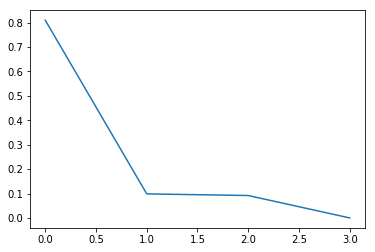

In [12]:
# Now, we will print how much "variance" each of the principal components explains. Roughly speaking, it tells us how much % of the spread lies
# along each direction
plt.plot(pca.explained_variance_ratio_)
plt.show()

As we can see above, the first component explains 80% of the total data spread. The second and third component explains roughly 10% each, 
and the last component explains nothing! 

### PCA on real dataset

The MNIST [dataset](http://yann.lecun.com/exdb/mnist/) is a famous set of photographs, each showing one handwritten digit. We will work with a processed
version of the data set. You can find the dataset in my github [repository](https://github.com/govg/acass/tree/master/data). Please download the different
datasets. The folder for each data set will also contain python files that show how to convert from raw data -> python array. Please take a look at those.

In [16]:
# Now let's work with some real data!
import os, sys

In [15]:
# The MNIST dataset defines images of the size 28x28. We treat the entire image as a row!
X = np.load("../data/mnist/Xtrain.npy")
print(X.shape)

(11022, 784)


In [18]:
# Since we assume images to be very correlated, we can now do PCA and see the effect of it on reducing dimensions!
# Note that this may time some time depending on how powerful your machine is. On my machine, doing PCA on the entire
# MNIST dataset that was loaded took a few seconds.
pca2 = PCA()
pca2.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

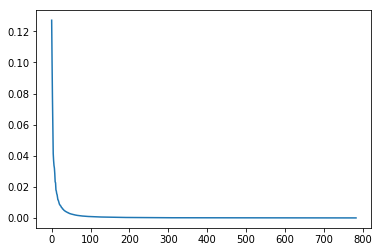

In [19]:
plt.plot(pca2.explained_variance_ratio_)
plt.show()

This is amazing! It tells us that of 784 possible diretions, only the first 100 or so are really important. Let's try out a very toy classification problem then, 
to see if this is actually the case.

In [20]:
Y = np.load("../data/mnist/Ytrain.npy")
print(Y.shape)

(11022,)


In [22]:
Xtr = pca2.transform(X)

In [21]:
# Choose only the first 100 features
Xtr = Xtr[:,0:100]
print(Xtr.shape)

(11022, 99)


In [23]:
# Now let's load the test data!
Xts = np.load("../data/mnist/Xtest.npy")
Yts = np.load("../data/mnist/Ytest.npy")
print(Xts.shape)
print(Yts.shape)

(2010, 784)
(2010,)


We will now compare the effect of PCA, by training a classifier on both our original data, as well as the transformed data. If the latter gives us as good 
performance as the former, then doing PCA was actually useful! Let's use a Random Forest classifier here, of course, you can use whatever you feel like.

In [36]:
from sklearn.ensemble import RandomForestClassifier

# The parameters are : 20 trees, each tree going up to 20 depth, and allow training of 3 trees in parallel. If you have a less powerful machine, you might want to reduce
# the n_jobs parameter to 1 or 2. 
clf1 = RandomForestClassifier(n_estimators = 30, max_depth = 10, n_jobs = 3)
clf2 = RandomForestClassifier(n_estimators = 30, max_depth = 10, n_jobs = 3)

In [37]:
# Train the first classifier on the original data
clf1.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=3, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [38]:
# Train the second classifier on the transformed data, only the first 100 directions
clf2.fit(Xtr, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=3, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [39]:
# Find the accuracy of the first classifier on the test data
print((Yts == clf1.predict(Xts)).mean())

0.993532338308


In [40]:
# Find the accuracy of the second classifier on the test data. Notice that we need to transform the testing data according to our PCA model before feeding it
# into the classifier
print((Yts == clf2.predict(pca2.transform(Xts))).mean())

0.946766169154


Alas! Doing PCA did not help in this situation. It could be because of multiple reasons. One simple reason could be that our Random Forest classifier does not 
try to exploit the geometry of the problem by finding seperating lines. In this case, if the features were correlated and had some sort of linear seperation, doing
PCA actually destroys that geometry somewhat. This should tell us that using PCA blindly can also be an issue. 